In [1]:
  from fastai.vision.all import *

In this chapter we are going to do two things:

- Make them better.
- Apply them to a wider variety of types of data.

for that we will have to learn all of the pieces of the deep learning puzzle:

- types of layers
- regularization methods
- optimizers
- how to put layers together into architectures
- labeling techniques

## From Dogs and Cats to Pet Breeds

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

Need to understand how this data is laid out (data layout are a vital piece of the deep learning puzzle). Data is usually provided in one of these two ways:

- Individual files representing items of data, possibly organized into folders or with filenames representing information about those items
- A table of data in which each row is an item and may include filenames providing connections between the data in the table and data in other formats

In [2]:
# To see what is in our dataset, we can use the ls method:

path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [3]:
# let's have a look inside the images directory:

(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_120.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_117.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_17.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_88.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_100.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_105.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_119.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_198.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_88.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_15.jpg')...]

We need to create a piece of code that extracts the breed from a single Path.

In [4]:
# To allow us to test our code, let's pick out one of these filenames:

fname = (path/"images").ls()[0]

The most powerful and flexible way to extract information from strings like this is to use a regex

In [5]:
# Let's use the findall method to try a regex against the filename of the fname object:

re.findall(r'(.+)_\d+.jpg$', fname.name)

['Siamese']

This regular expression plucks out all the characters leading up to the last underscore character, as long as the subsequent characters are numerical digits and then the JPEG file extension.

In [6]:
# Let's use regex to label the whole dataset(use data block API):

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 # implement a fastai data augmentation strategy that we call presizing
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )
dls = pets.dataloaders(path/"images")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


## Presizing
Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

- We need our images to have the same dimensions, so that they can collate into tensors to be passed to the GPU.
- We want to minimize the number of distinct augmentation computations we perform.

presizing adopts two strategies:

- Resize images to relatively “large” dimensions—that is, dimensions significantly larger than the target training dimensions.
- Compose all the common argumentation operations into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.

### Checking and Debugging a DataBlock
No guarantee that your template is going to work on your data source as you intend. So, before training a model, you should always check your data.

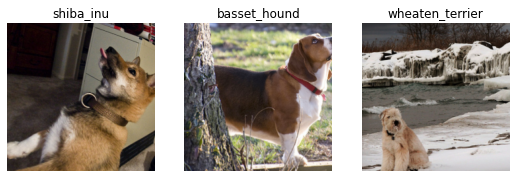

In [7]:
# You can do this using the show_batch method:

dls.show_batch(nrows=1, ncols=3)

To debug this, we encourage you to use the summary method.

In [ ]:
# Here is what the summary would look like in that case:

pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(seed=42),
                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name')
                  )

pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_124.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_124.jpg
    applying partial gives
      staffordshire_bull_terrier
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(34)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(34))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 's

RuntimeError: ignored

In [8]:
# For this initial test, we'll use the same simple model:

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.537220,0.306813,0.105548,01:29


epoch,train_loss,valid_loss,error_rate,time
0,0.515337,0.340497,0.113667,01:36
1,0.339848,0.230156,0.071042,01:36


## Cross-Entropy Loss
loss function similar to before with two benefits:
- It works even when our dependent variable has more than two categories.
- It results in faster and more reliable training.

First understand what the actual data and activations that are seen by the loss function look like.

### Viewing Activations and Labels
Take a look at the activations of our model

In [9]:
# get a batch of real data from our DataLoaders:

x,y = dls.one_batch() # returns the dependent and independent variables, as a mini-batch

In [10]:
# what contained in our dependent variable:

y

TensorCategory([29, 17, 29,  0, 14, 22, 32, 17,  8,  9, 29, 36,  3, 21, 15, 32,  6, 11,
         1, 17, 36, 26, 14, 16, 25,  4, 22, 28, 14, 31, 17, 19,  2, 31, 12, 35,
        13,  5, 18, 30, 22, 30, 19, 27, 31, 11, 25, 30, 23, 21, 10,  2, 23, 24,
         9, 16, 20, 35, 13, 15, 23,  3,  9, 36], device='cuda:0')

- batch_size = 64 (64 rows in this tensor)
- Each_row = 0 <= single_int <= 36 (37 possible pet breeds)
- prediction: the activations of the final layer of our neural network

In [11]:
# view the predictions(takes either dataset index or iterator batches and returns preds+targ):

preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([2.3151e-08, 9.3704e-08, 2.0959e-07, 4.5530e-08, 1.1372e-06, 1.2051e-07,
        1.0854e-09, 7.4880e-07, 1.3952e-08, 3.9612e-08, 8.0870e-06, 1.6292e-06,
        1.5405e-04, 7.8369e-07, 2.0012e-07, 2.4142e-07, 6.0141e-05, 1.7136e-07,
        3.9595e-08, 2.3276e-07, 5.3172e-08, 2.2503e-06, 1.4951e-06, 3.4997e-06,
        1.0057e-06, 8.5366e-07, 2.6074e-07, 4.2415e-07, 3.6955e-08, 9.9973e-01,
        5.1724e-06, 6.2697e-08, 1.4023e-07, 1.2545e-07, 2.3038e-05, 1.2186e-06,
        1.7363e-07])

In [12]:
# the actual predictions are 37 probs between 0 and 1, add up to 1:
len(preds[0]), preds[0].sum()

(37, TensorBase(1.))

### Softmax
To transform the activations of our model into predictions like this , we used softmax activation function.

In classification model, we use it in final layer to ensure that the activations are bet 0 and 1, and that they sum to 1.

It's similar to the sigmoid function

In [13]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  


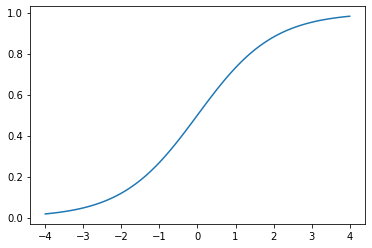

In [14]:
# sigmoid look like this:
plot_function(torch.sigmoid, min=-4,max=4)

We can apply this function to a single col of activations from a NN and get back a col of no. bet 0 and 1.

For more categories in our target: need an activation per category

NN that predicts 3s and 7s that returns two activations: first step towards creating more general approach

In [15]:
# use some random num with std deviation of 2(multi randn by 2), 6 imgs 2 categ:

acts = torch.randn((6,2))*2
acts

tensor([[-0.9916, -2.2545],
        [ 0.1560, -1.9368],
        [-0.6164,  1.1047],
        [-2.0798, -2.1778],
        [ 1.6429, -3.7728],
        [-1.2445, -2.9512]])

In [16]:
# taking sigmoid directly don't get rows that add to 1:

acts.sigmoid()

tensor([[0.2706, 0.0950],
        [0.5389, 0.1260],
        [0.3506, 0.7511],
        [0.1111, 0.1018],
        [0.8379, 0.0225],
        [0.2237, 0.0497]])

In ch4 NN created a single activation per image, which we passed through the sigmoid fn: repersented the model's confidence that the i/p was a 3.
- In binary problems, the target can be treated as a single Boolean value, as we did in mnist_loss
- binary problem can be more general group of classifiers with any number of categories: In this case, two categories

A single pair of activations indicateds the relative confidence of the i/p being a 3 vs being a 7 by which is higher then how much.

This is another way of representing the same problem, we would be able to use sigmoid directly on the two-activation version of NN.

In [17]:
# take diff bet the NN activations(reflects confidence i/p is 3 than 7)
# then use sigmoid of that:

(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.7795, 0.8902, 0.1517, 0.5245, 0.9956, 0.8464])

In [18]:
# prob of it being a 7 by value subtracted from 1:

1-(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.2205, 0.1098, 0.8483, 0.4755, 0.0044, 0.1536])

In [19]:
# to work with more than 2 columns need softmax:

def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [20]:
# check that softmax returns the same values as sigmoid

sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

**softmax** is the multi-category equivalent of **sigmoid**

Softmax is the first part of the cross-entropy loss—the second part is log likelihood.

### Log Likelihood
When we calculate the loss for our MNIST example in the preceding chapter, we used this:

In [21]:
def mnist_loss(inputs, targets):
  inputs = inputs.sigmoid()
  return torch.where(targets==1, 1-inputs, inputs).mean()

After Softmax
- activations are bet 0 and 1, sum to 1 for each row
- targets are integers bet 0 and 36

When we treat a binary classification as a general classification problem with two categories:
- we now two col containing the equivalent of inputs and 1-inputs.
- we need to select from the appropriate column

In [22]:
# implement this in PyTorch
# our synthetic 3s and 7s example, let's say these are our labels:
targ = tensor([0,1,0,1,1,0])

In [24]:
# these are the softmax activations:
sm_acts

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

In [25]:
# then for each item of targ, select the appropriate column of sm_acts using tensor indexing:

idx = range(6)
sm_acts[idx, targ]

tensor([0.7795, 0.1098, 0.1517, 0.4755, 0.0044, 0.8464])

by defination Softmax: they add up to 1 minus the activation corresponding to the correct label as high as possible must mean we're also decreasing the activations of the remaining columns.

In [26]:
# PyTorch provides a function that does exactly the same thing as sm_acts[range(n),targ]: Negative log likelihood:

-sm_acts[idx, targ]

tensor([-0.7795, -0.1098, -0.1517, -0.4755, -0.0044, -0.8464])

In [27]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.7795, -0.1098, -0.1517, -0.4755, -0.0044, -0.8464])

#### Taking the log
The previous function works in probs(bet 0 and 1) means our model don't care whether it predicts 0.99 or 0.999(close but .999 10x confident than .99), so we want to transform to -ve infinity to +ve infinity by using mathematical func Logrithm

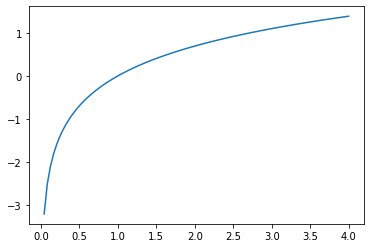

In [29]:
# it is not defined for numbers less than 0 and looks like this:

plot_function(torch.log, min=0, max=4)

The logarithm function has this identity:

- y = b^a
- a = log(y,b) : log y base b

The key thing to know about logarithms is this relationship:
- log(a*b) = log(a) + log(b)

It means that logarithms increase linearly when the underlying signal increases exponentially or multiplicatively.

When we first take the softmax, and then the log likelihood of that, that combination is called cross-entropy loss.

In [30]:
# does log_softmax and then nll_loss:

loss_func = nn.CrossEntropyLoss()

In [31]:
# it gives you an object that behaves like a function:

loss_func(acts, targ)

tensor(1.7790)

In [32]:
# All PyTorch loss func are provided in two forms, class and plain functional form, in the F.namespace:

F.cross_entropy(acts, targ)

tensor(1.7790)

In [33]:
#  PyTorch loss functions take the mean of the loss, reduction='none' to disable that:

nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.2491, 2.2091, 1.8857, 0.7434, 5.4201, 0.1667])

The gradient of cross_entropy(a,b) = softmax(a)-b

softmax(a) is final activation of model: gradient is proportional to (preds-targ)

now see some ways to interpret our model’s predictions

### Model Interpretation
Metrics: not used in optimization process, but to help humans understand what's going on.

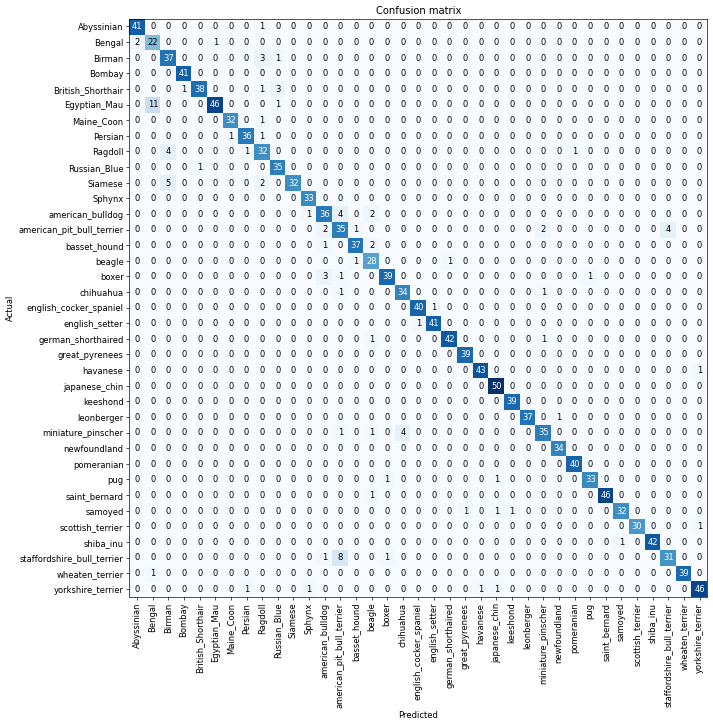

In [34]:
# use a confusion matrix to see where our model is doing well and where it's doing badly:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [35]:
# confusion matrix is very hard to read: 37x37 entries
# use the most_confused method, to show cells of confusion matrix with the most incorrect predictions:

interp.most_confused(min_val=5)

[('Egyptian_Mau', 'Bengal', 11),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 8),
 ('Siamese', 'Birman', 5)]

## Improving Our Model
First step: set a learning rate

### The Learning Rate Finder
Low Learning Rate: 
- take many epochs to train model
- waste time
- have problems with overfitting: every epoch give model a chance to memorize it

In [36]:
# make our learning rate high:

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.618363,4.602708,0.474966,01:38


epoch,train_loss,valid_loss,error_rate,time
0,3.529252,1.806525,0.569012,01:42


Learning rate finder:
- small learning rate on one mini-batch
- inc. learning rate by certain percentage on another mini-batch
- keep doing this until the loss gets worse instead better
- select learning rate a bit lower than this point

pick either of these:
- One order of magnitude less than where the minimum loss was achieved (i.e. the minimum divided by 10)
-  the last point where the loss was clearly decreasing

In [45]:
# we didn’t specify a learning rate, using the default value from the fastai library (which is 1e-3):

learn = cnn_learner(dls, resnet34, metrics=error_rate)

ValueError: ignored

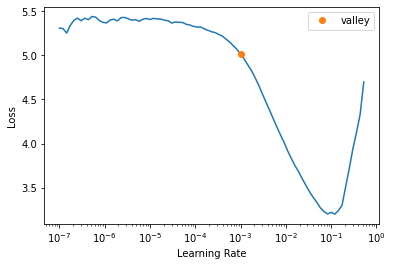

In [46]:
lr_min,lr_steep = learn.lr_find()

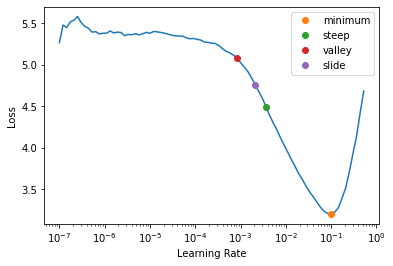

In [47]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [39]:
print(f"Minimum/10: {lr_minimum:.2e}, steepest point: {lr_steep:.2e}")

NameError: ignored

In [48]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.63e-03


In [49]:
# In this learning rate plot, it appears that a learning rate around 3e-3 would be appropriate, so let’s choose that:

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.314233,0.324841,0.106225,01:37


epoch,train_loss,valid_loss,error_rate,time
0,0.569506,0.451837,0.135318,01:43
1,0.326042,0.223775,0.071042,01:43


how we can fine-tune the weights of a pretrained model.

### Unfreezing and Transfer Learning
When we create a model from a pretrained network, fastai automatically freezes all of the pretrained layers for us. When we call the fine_tune method, fastai does two things:
- Trains the randomly added layers for one epoch, with all other layers frozen
- Unfreezes all the layers, and trains them for the number of epochs requested

 try doing this manually

In [52]:
# train the randomly added layers for three epochs, using fit_one_cycle.

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.138218,0.375515,0.110961,01:39
1,0.544277,0.239107,0.079838,01:39
2,0.313757,0.206142,0.067659,01:39


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79cefca7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79cefca7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

In [53]:
# we'll unfreeze the model:

learn.unfreeze()

SuggestedLRs(minimum=9.12010818865383e-08, steep=6.309573450380412e-07)

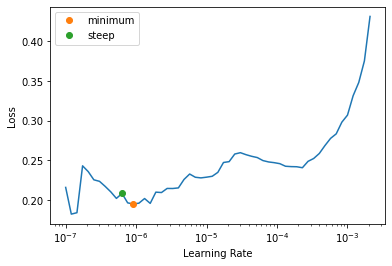

In [56]:
# run lr_find again, after 3epochs, learning rate isn't appropriate anymore:

learn.lr_find(suggest_funcs=(minimum, steep))

In [57]:
# train at a suitable learning rate:

learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.254723,0.201687,0.065629,01:45
1,0.255841,0.197582,0.060217,01:44
2,0.212072,0.191197,0.063599,01:43
3,0.194675,0.186064,0.060217,01:42
4,0.178819,0.184807,0.058187,01:42
5,0.189206,0.184812,0.059540,01:43


## Discriminative Learning Rates
The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those: discriminative learning rate

The first layer learns very simple foundations, like edge and gradient detectors; these are likely to be just as useful for nearly any task. The later layers learn much more complex concepts, like “eye” and “sunset,” which might not be useful in your task at all. So it makes sense to let the later layers fine-tune more quickly than earlier layers.


In [60]:
# set only the lowest layer of our net to a learning rate of 1e-6
# the other layers will scale up to 1e-4
# train for a while and see what happens:

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.147867,0.311287,0.100135,01:36
1,0.529498,0.244937,0.083221,01:36
2,0.342443,0.223622,0.079161,01:34


epoch,train_loss,valid_loss,error_rate,time
0,0.267282,0.217185,0.071719,01:41
1,0.264711,0.216012,0.072395,01:41
2,0.249189,0.200826,0.066306,01:41
3,0.233137,0.191749,0.062923,01:42
4,0.204181,0.182479,0.064953,01:41
5,0.184133,0.187333,0.063599,01:40
6,0.174979,0.185795,0.060893,01:40
7,0.157338,0.184494,0.059540,01:39
8,0.151359,0.179672,0.063599,01:40
9,0.141796,0.178094,0.056834,01:40


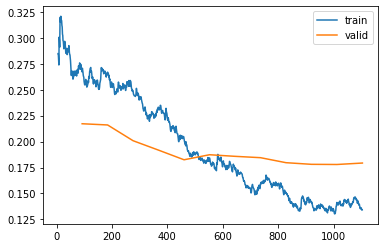

In [61]:
# fastai can show us a graph of the training and validation loss:

learn.recorder.plot_loss()

training loss getting better + validation loss improveement slow = model start overfit(overconfident of its predictions)

In the end, what matters is your accuracy, or more generally your chosen metrics, not the loss. Loss used for optimization.

## Selecting the Number of Epochs
FIRST: according to time to wait

SECOND: according to metrics:
- getting better even in your final epochs, not trained for too long.

Before the days of 1cycle training, it was common to save the model at the end of each epoch, and then select whichever model had the best accuracy out of all of the models saved in each epoch. This is known as early stopping

## Deeper Architectures
a model with more parameters can model your data more accurately

A larger (more layers and parameters; sometimes described as the capacity of a model) version of a ResNet will always be able to give us a better training loss, but it can suffer more from overfitting, because it has more parameters to overfit with.

need to lower the size of your batches to avoid an out-of-memory error

deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is mixed-precision training. This refers to using less-precise numbers (half-precision floating point, also called fp16) where possible during training.

In [62]:
# try a ResNet-50 now with mixed precision:

from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.264120,0.270102,0.094723,02:07
1,0.588147,0.270745,0.087280,02:02
2,0.427403,0.260691,0.086604,02:02


epoch,train_loss,valid_loss,error_rate,time
0,0.283743,0.241184,0.075101,02:36
1,0.289302,0.291349,0.079838,02:35
2,0.259452,0.298478,0.083221,02:35
3,0.159871,0.248297,0.071042,02:35
4,0.092286,0.216320,0.058863,02:34
5,0.057692,0.207262,0.053451,02:34


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79cefca7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79cefca7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho